In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import joblib

plt.style.use('seaborn-v0_8')
sns.set_context("notebook")


CSV_PATH = "/Breast Cancer Wisconsin (Diagnostic) Data Set.csv"
RND = 42

print("CSV exists:", os.path.exists(CSV_PATH))


CSV exists: True


In [ ]:

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())
print("\nDtypes:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())


Shape: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN



Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Dtypes:
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimensio

In [ ]:

for col in df.columns:
    if df[col].dtype == object:
        coerced = pd.to_numeric(df[col], errors='coerce')
        valid_ratio = coerced.notna().sum() / max(1, len(coerced))
        if valid_ratio >= 0.5:
            df[col] = coerced
            print(f"Coerced to numeric: {col} (valid ratio {valid_ratio:.2f})")


dupes = df.duplicated().sum()
print("Duplicates:", dupes)
if dupes:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Dropped duplicates. New shape:", df.shape)


print("\nMissing values now:")
print(df.isnull().sum())


Duplicates: 0

Missing values now:
id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
frac

In [ ]:

possible_targets = [c for c in df.columns if c.lower() in ('diagnosis','target','label','class')]
if 'diagnosis' in df.columns:
    target_col = 'diagnosis'
elif possible_targets:
    target_col = possible_targets[0]
else:
    target_col = df.columns[-1]

print("Using target:", target_col)
print("Unique values:", df[target_col].unique()[:10])


if df[target_col].dtype == object:
    uniq = sorted([str(x).upper() for x in df[target_col].unique()])
    if set(uniq) == set(['B','M']):
        df[target_col] = df[target_col].map({'M':1, 'B':0}).astype(int)
        print("Mapped M/B to 1/0.")
    else:
        le = LabelEncoder()
        df[target_col] = le.fit_transform(df[target_col].astype(str))
        print("Label-encoded target; classes:", list(le.classes_))


for idc in ['id','ID','Id','index','patient_id','pid']:
    if idc in df.columns and idc != target_col:
        df = df.drop(columns=[idc])
        print("Dropped ID column:", idc)

print("After encoding shape:", df.shape)


Using target: diagnosis
Unique values: ['M' 'B']
Mapped M/B to 1/0.
Dropped ID column: id
After encoding shape: (569, 32)


In [ ]:

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train_df, X_temp_df, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)

X_val_df, X_test_df, y_val, y_test = train_test_split(
    X_temp_df, y_temp, test_size=0.5, stratify=y_temp, random_state=RND
)

print("Train:", X_train_df.shape, y_train.shape)
print("Val:  ", X_val_df.shape, y_val.shape)
print("Test: ", X_test_df.shape, y_test.shape)


Train: (455, 31) (455,)
Val:   (57, 31) (57,)
Test:  (57, 31) (57,)


In [ ]:
)
num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train_df.columns if c not in num_cols]

print("Numeric cols:", len(num_cols), "Categorical cols:", cat_cols)


imputer = SimpleImputer(strategy='median')
X_train_num = imputer.fit_transform(X_train_df[num_cols])
X_val_num   = imputer.transform(X_val_df[num_cols])
X_test_num  = imputer.transform(X_test_df[num_cols])

if cat_cols:
    X_train_cat = X_train_df[cat_cols].fillna('Unknown')
    X_val_cat   = X_val_df[cat_cols].fillna('Unknown')
    X_test_cat  = X_test_df[cat_cols].fillna('Unknown')
    # one-hot
    X_all_cat = pd.get_dummies(pd.concat([X_train_cat, X_val_cat, X_test_cat], axis=0), drop_first=True)
    # split back
    n_train = len(X_train_cat)
    n_val = len(X_val_cat)
    X_train_cat_enc = X_all_cat.iloc[:n_train, :].values
    X_val_cat_enc   = X_all_cat.iloc[n_train:n_train+n_val, :].values
    X_test_cat_enc  = X_all_cat.iloc[n_train+n_val:, :].values
    # concatenate numeric + cat
    X_train_pre = np.hstack([X_train_num, X_train_cat_enc])
    X_val_pre   = np.hstack([X_val_num, X_val_cat_enc])
    X_test_pre  = np.hstack([X_test_num, X_test_cat_enc])
else:
    X_train_pre = X_train_num
    X_val_pre   = X_val_num
    X_test_pre  = X_test_num


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_pre)
X_val   = scaler.transform(X_val_pre)
X_test  = scaler.transform(X_test_pre)


print("Any NaN after preprocessing?", np.isnan(X_train).any(), np.isnan(X_val).any(), np.isnan(X_test).any())


Numeric cols: 31 Categorical cols: []
Any NaN after preprocessing? False False False


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [ ]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, solver='liblinear', random_state=RND),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=RND),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RND),
    "SVM": SVC(kernel='rbf', probability=True, random_state=RND)
}

fitted = {}
for name, clf in models.items():
    print(f"\nTraining {name} ...")
    clf.fit(X_train, y_train)
    fitted[name] = clf
    val_pred = clf.predict(X_val)
    print(f"Val accuracy ({name}):", accuracy_score(y_val, val_pred))



Training LogisticRegression ...
Val accuracy (LogisticRegression): 0.9649122807017544

Training KNN ...
Val accuracy (KNN): 0.9298245614035088

Training DecisionTree ...
Val accuracy (DecisionTree): 0.9298245614035088

Training RandomForest ...
Val accuracy (RandomForest): 0.9649122807017544

Training SVM ...
Val accuracy (SVM): 0.9649122807017544


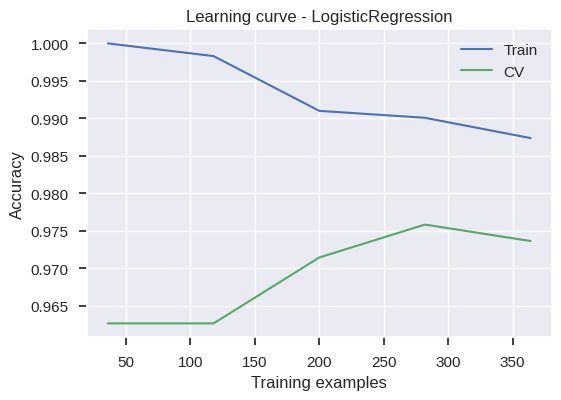

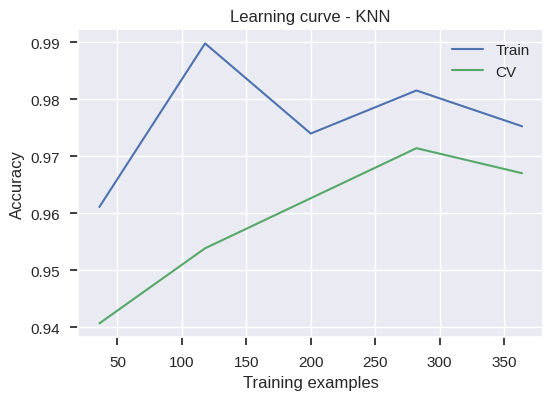

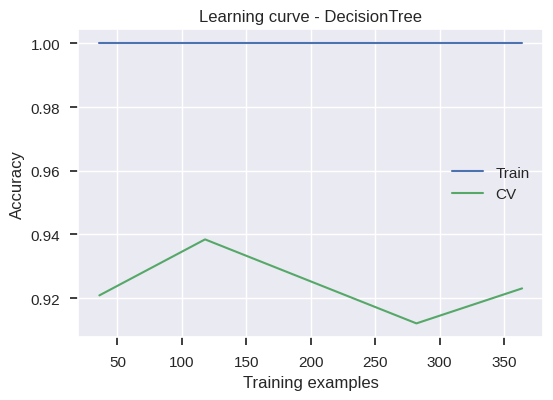

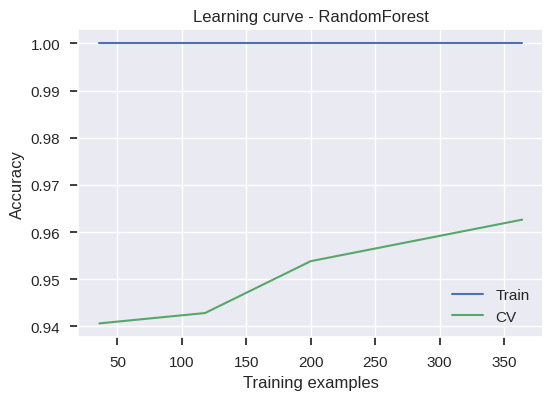

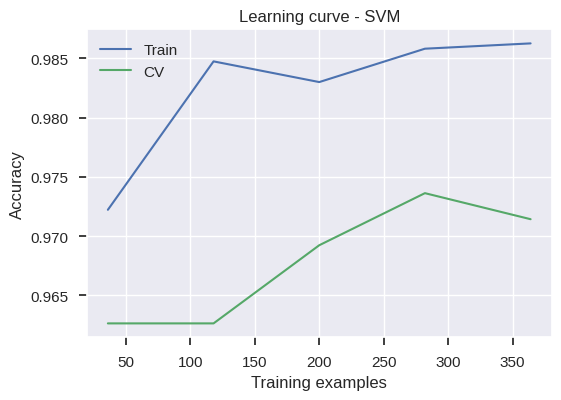

In [ ]:

from sklearn.model_selection import StratifiedKFold, learning_curve

def plot_lc(estimator, X, y, title):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=skf,
                                                           train_sizes=np.linspace(0.1,1.0,5),
                                                           scoring='accuracy', n_jobs=1)
    tr = train_scores.mean(axis=1)
    val = val_scores.mean(axis=1)
    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, tr, label='Train')
    plt.plot(train_sizes, val, label='CV')
    plt.title("Learning curve - " + title)
    plt.xlabel("Training examples"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

for name, clf in fitted.items():
    plot_lc(clf, X_train, y_train, name)


Model: LogisticRegression
Confusion Matrix:
 [[35  1]
 [ 0 21]]


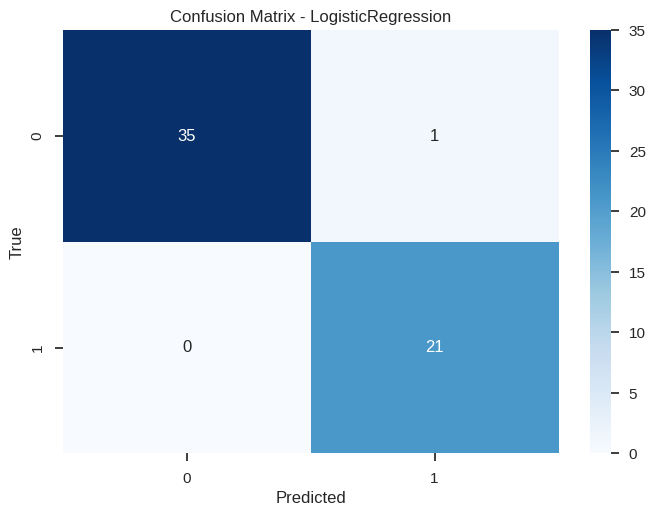


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9722    0.9859        36
           1     0.9545    1.0000    0.9767        21

    accuracy                         0.9825        57
   macro avg     0.9773    0.9861    0.9813        57
weighted avg     0.9833    0.9825    0.9825        57



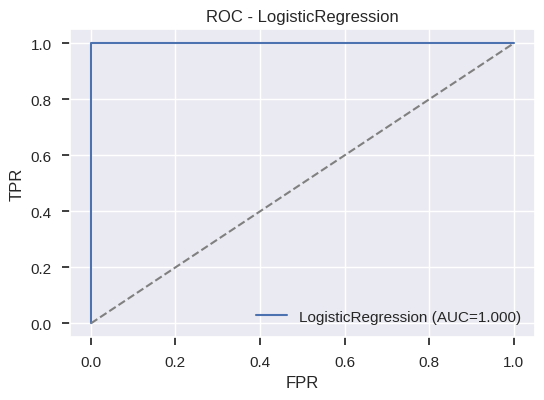


Model: KNN
Confusion Matrix:
 [[36  0]
 [ 1 20]]


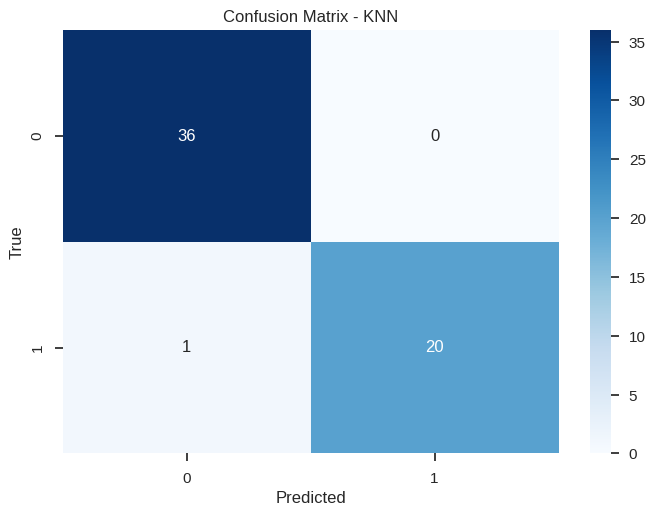


Classification Report:
              precision    recall  f1-score   support

           0     0.9730    1.0000    0.9863        36
           1     1.0000    0.9524    0.9756        21

    accuracy                         0.9825        57
   macro avg     0.9865    0.9762    0.9810        57
weighted avg     0.9829    0.9825    0.9824        57



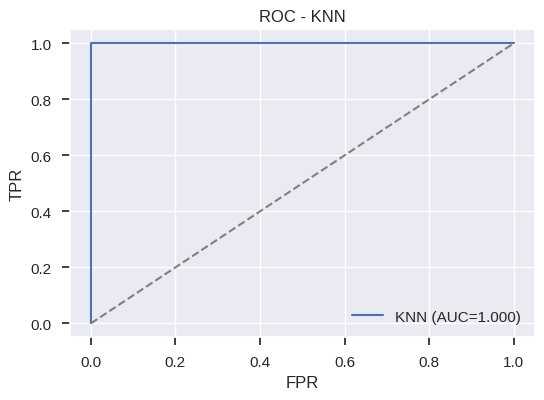


Model: DecisionTree
Confusion Matrix:
 [[35  1]
 [ 3 18]]


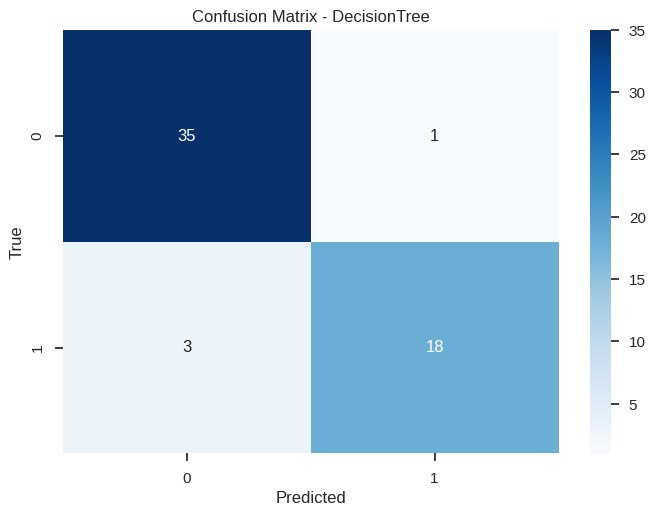


Classification Report:
              precision    recall  f1-score   support

           0     0.9211    0.9722    0.9459        36
           1     0.9474    0.8571    0.9000        21

    accuracy                         0.9298        57
   macro avg     0.9342    0.9147    0.9230        57
weighted avg     0.9307    0.9298    0.9290        57



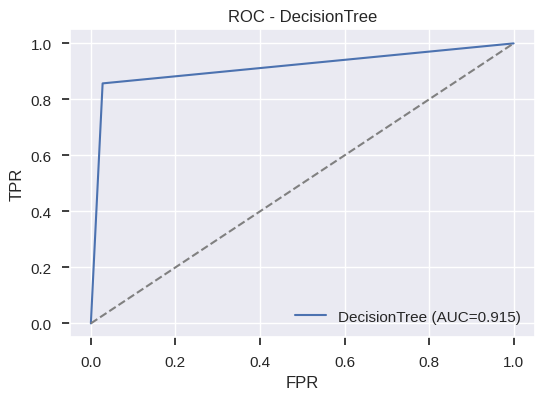


Model: RandomForest
Confusion Matrix:
 [[36  0]
 [ 2 19]]


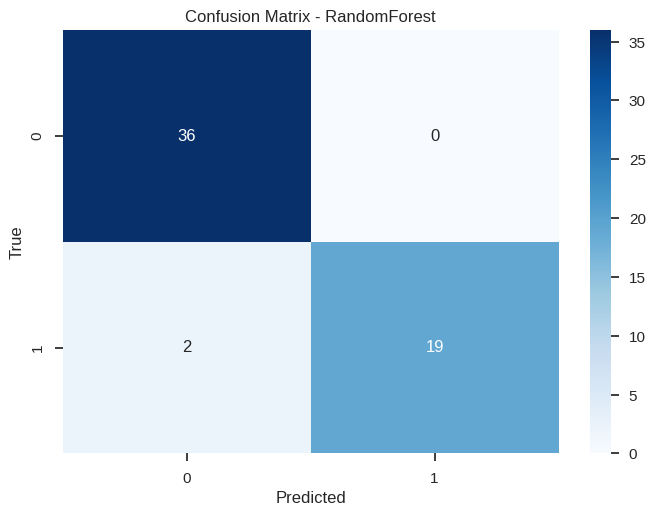


Classification Report:
              precision    recall  f1-score   support

           0     0.9474    1.0000    0.9730        36
           1     1.0000    0.9048    0.9500        21

    accuracy                         0.9649        57
   macro avg     0.9737    0.9524    0.9615        57
weighted avg     0.9668    0.9649    0.9645        57



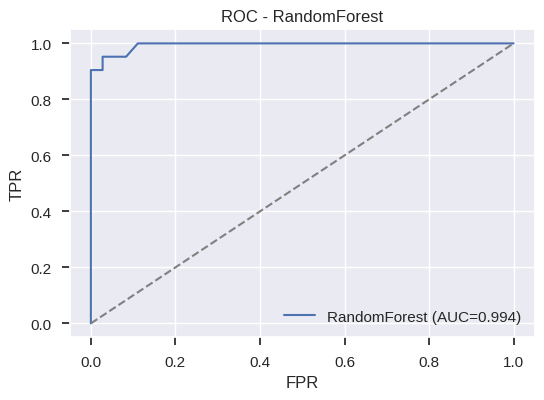


Model: SVM
Confusion Matrix:
 [[36  0]
 [ 1 20]]


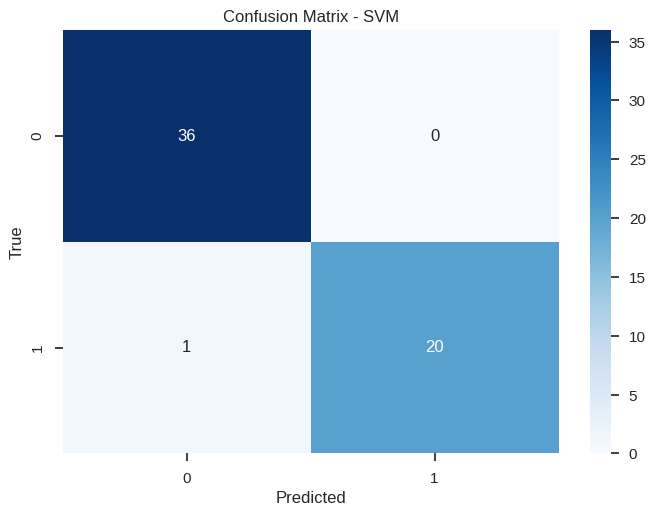


Classification Report:
              precision    recall  f1-score   support

           0     0.9730    1.0000    0.9863        36
           1     1.0000    0.9524    0.9756        21

    accuracy                         0.9825        57
   macro avg     0.9865    0.9762    0.9810        57
weighted avg     0.9829    0.9825    0.9824        57



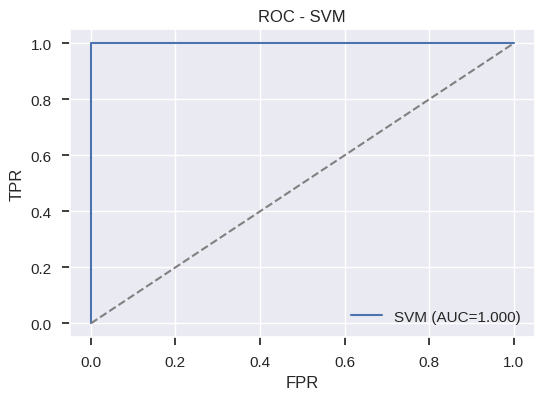

In [ ]:

for name, clf in fitted.items():
    print("\n" + "="*50)
    print("Model:", name)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))


    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:,1]
    else:
        try:
            y_score = clf.decision_function(X_test)
        except:
            y_score = None

    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {name}")
        plt.legend(); plt.show()
    else:
        print("No score for ROC.")
